In [174]:
"""Data inspection."""

'Data inspection.'

In [195]:
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy import signal

import warnings
warnings.filterwarnings("ignore")

ELECTRODE_ID = 1
data_file = f'2018-05-31_15-43-39/CSC{ELECTRODE_ID}.ncs'

In [232]:
# Config parameters:
ops_fs = 32000 # sampling rate s^-1

ops_lowcut = 600 # Hz
ops_highcut = 7000 # Hz
ops_delta = 100

ops_cheby_order = 6
ops_cheby_passband_ripple = 0.01

ops_fir_order = 50

ops_min_consecutive = 5
ops_flat_window = 100

ops_spike_threshold = 3.1 # spike threshold in standard deviations
ops_clip = 30 # Peak window in terms of number of samples, not ms!

ops_nyq = np.float64(ops_fs / 2)

<class 'numpy.float64'>


In [197]:
# Get Data
header_size = 16 * 1024

with open(data_file, 'rb') as fid:
    fid.seek(header_size)

    # Read data according to Neuralynx information
    data_format = np.dtype([
        ('TimeStamp', np.uint64),
        ('ChannelNumber', np.uint32),
        ('SampleFreq', np.uint32),
        ('NumValidSamples', np.uint32),
        ('Samples', np.int16, 512)])
    raw = np.fromfile(fid, dtype=data_format)

In [198]:
# Inspect Data
print(raw.shape)
print(raw.dtype)

# Look at a field - each field is a usual ndarray
print(raw['SampleFreq'])  # Good: the sample frequency is the same everywhere: 32000Hz
print(raw['SampleFreq'].shape)  # ?: shape is (50863,)

# Look at Channel Number
print(raw['ChannelNumber'])  # ?: ChannelNumber is 0 everywhere
print(raw['ChannelNumber'].shape)

# Look at TimeStamp
print(raw['TimeStamp'])  # ?: In which units are the timestamps?
print(raw['TimeStamp'].shape)

(50863,)
[('TimeStamp', '<u8'), ('ChannelNumber', '<u4'), ('SampleFreq', '<u4'), ('NumValidSamples', '<u4'), ('Samples', '<i2', (512,))]
[32000 32000 32000 ... 32000 32000 32000]
(50863,)
[0 0 0 ... 0 0 0]
(50863,)
[104904552095 104904568095 104904584095 ... 105717896269 105717912269
 105717928269]
(50863,)


In [199]:
# Look at the Samples
print(raw['Samples'])
print(raw['Samples'].shape)  # ?: shape is (50863, 512): what is 512?

[[  977  1192  1241 ...  1837  2042  2082]
 [ 1704  1230  1031 ...   102   189   610]
 [  498   309   418 ...  1041  1193  1127]
 ...
 [-2309 -2573 -2721 ... -2265 -2348 -2373]
 [-2466 -2587 -2486 ...  4063  4096  4069]
 [ 4258  4316  4192 ...  4063  4096  4069]]
(50863, 512)


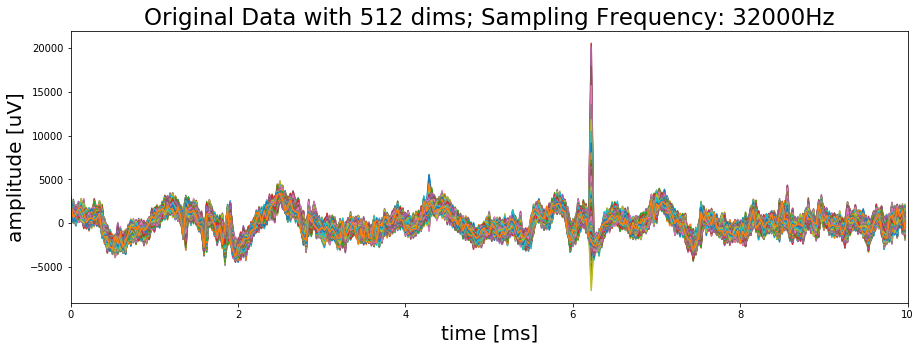

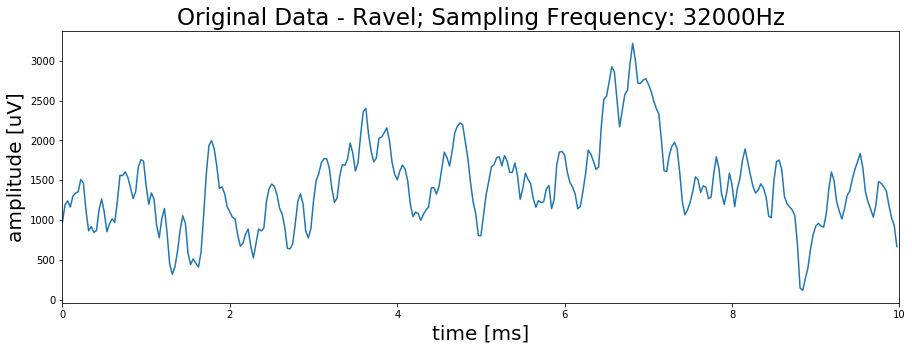

In [279]:
# Plot first secs of this electrode
def plot_samples(data, n_ms, title=''):
    n_secs = 0.001 * n_ms
    # Determine duration of recording in seconds
    dur_sec = data.shape[0] / sf
    time = np.linspace(0, dur_sec, data.shape[0])
    # Plot first second of data
    fig, ax = plt.subplots(figsize=(15, 5))
    
    last_time = int(round(n_secs*sf))
    
    ax.plot(1000*time[0:last_time], data[0:last_time])
    ax.set_title(title + 'Sampling Frequency: {}Hz'.format(sf),
                 fontsize=23)
    ax.set_xlim(0, 1000*time[last_time])
    ax.set_xlabel('time [ms]', fontsize=20)
    ax.set_ylabel('amplitude [uV]', fontsize=20)
    plt.show()
    
samples_orig = raw['Samples']
samples = samples.ravel()

# Works with and without ravel
plot_samples(samples_orig, 10, title='Original Data with 512 dims; ')
plot_samples(samples, 10, title='Original Data - Ravel; ')

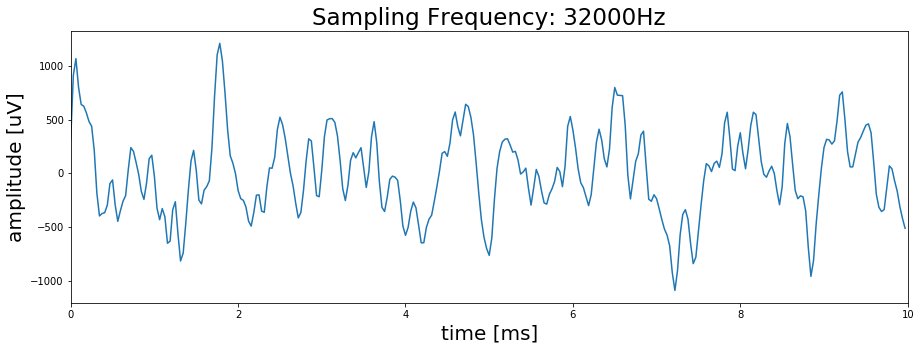

In [281]:
def filter_passband(samples, low=500, high=9000, sf=-1, order=2):
    """ 
    Filter from tutorial: 
    https://towardsdatascience.com/using-signal-processing-to-extract-neural-events-in-python-964437dc7c0
    to remove 60Hz that correspond to electronics.
    """
    # Set bands
    low = low / ops_nyq
    high = high / ops_nyq
    # Calculate coefficients
    b, a = signal.butter(order, [low, high], btype='band')
    # Filter signal
    filtered_samples = signal.lfilter(b, a, samples)
    return filtered_samples

# Apply only this filter to raw data
samples_passband = filter_passband(samples, sf=ops_fs)
plot_samples(samples_passband, 10)

In [228]:
type(nyq)

numpy.float64

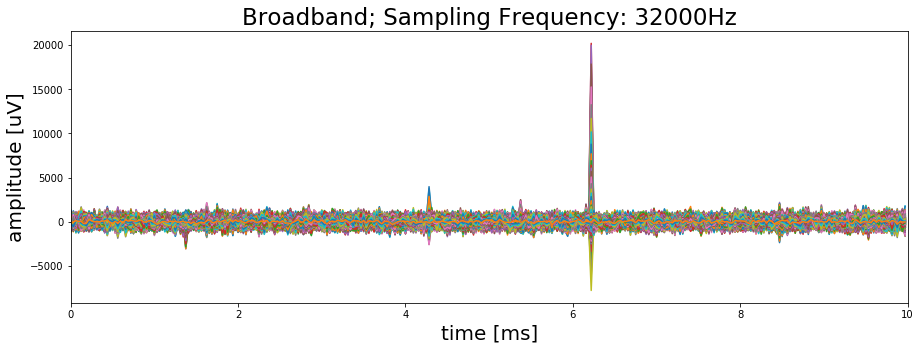

In [234]:
def filter_cheby(samples):
    """
    First filter applied by Eric, in matlab code from Archive.zip.
    IIR cuts low frequencies with a sharp filter.
    Note: Similar to the passband filter from the tutorial.
    """
    filter_order = ops_cheby_order
    max_ripple = ops_cheby_passband_ripple
    critical_frequencies = [ops_lowcut - 4 * ops_delta, ops_highcut + 4 * ops_delta] / ops_nyq

    b0, a0 = signal.cheby1(
        N=filter_order, 
        rp=max_ripple,
        Wn=critical_frequencies, 
        btype='bandpass')
    filtered_samples = signal.filtfilt(b0, a0, samples)
    return filtered_samples

# Apply only this filter to raw data
samples_cheby = filter_cheby(samples)
plot_samples(samples_cheby, 10)

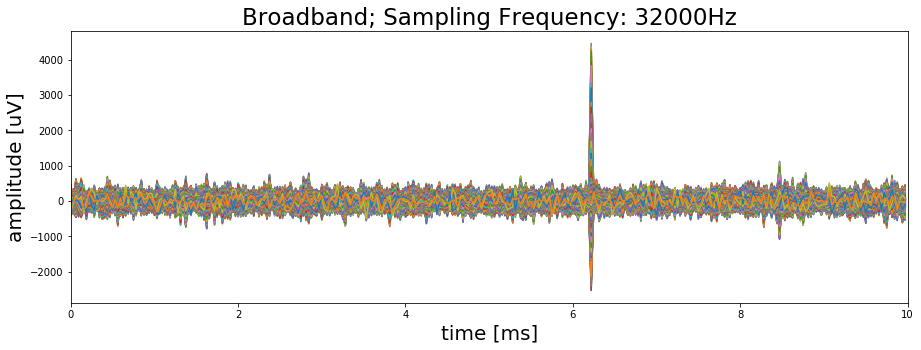

In [237]:
def filter_firwin(samples):
    """
    Second filter applied by Eric, in matlab code from Archive.zip.
    Low order Hann Filter.
    
    Rmk: Length of the filter = number of coefficients, i.e. the filter order + 1.
    """
    filter_length = ops_fir_order + 1 
    cutoff_frequencies = [ops_lowcut - ops_delta, ops_highcut + ops_delta] / ops_nyq
    b1 = signal.firwin(
        numtaps=filter_length,
        cutoff=cutoff_frequencies, 
        window='hann')
    beq = np.convolve(b1, b1) # 2 stage filter
    
    # Applying filters, with 0 phase lag
    filtered_samples = signal.filtfilt(beq, 1, samples)
    return filtered_samples

# Apply only this filter to raw data
samples_firwin = filter_firwin(samples_cheby)
plot_samples(samples_firwin, 10)

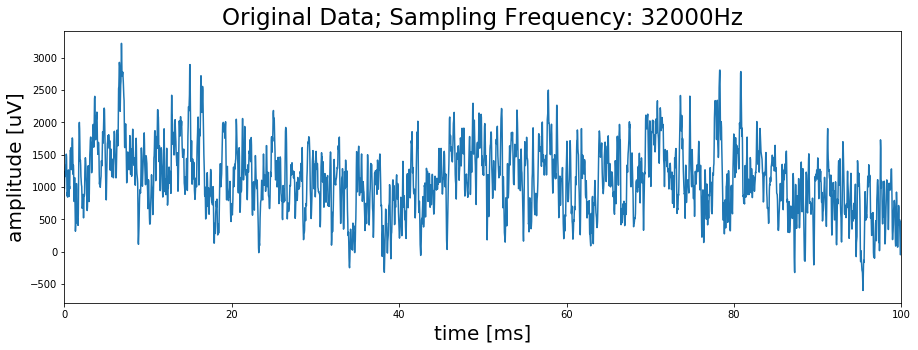

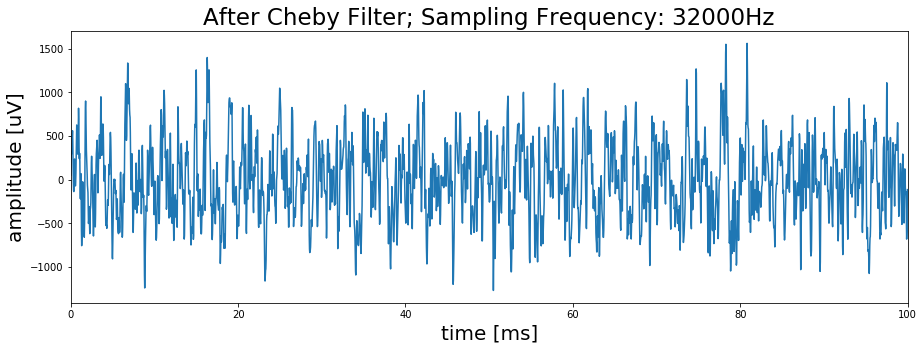

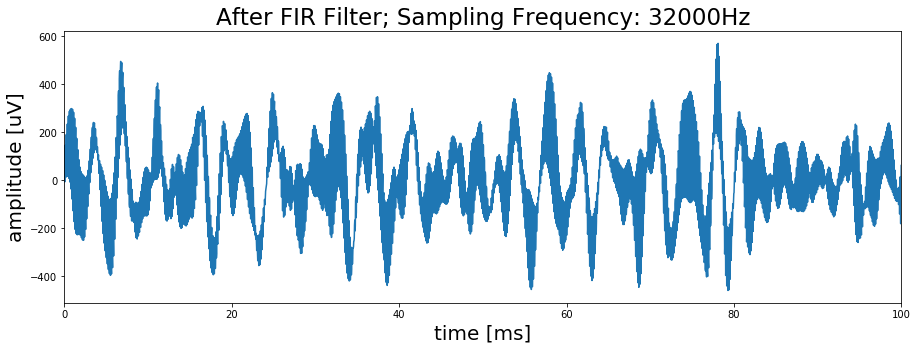

In [255]:
# Consecutive filters on same graph
plot_samples(samples_ravel, 100, title='Original Data; ')

samples_cheby_ravel = filter_cheby(samples_ravel)
plot_samples(samples_cheby_ravel, 100, title='After Cheby Filter; ')

samples_firwin_ravel = filter_firwin(samples_cheby_ravel)
plot_samples(samples_firwin_ravel, 100, title='After FIR Filter; ')

In [79]:
def consecutiveIntegers(X, min_consecutive):
    consec = {}    
    counter = 0
    idx = 0
    
    while (idx < len(X)-1):
        start_idx = X[idx]
        
        while (X[idx+1] == X[idx] + 1):
            idx += 1
            if idx == len(X)-1:
                break
        
        end_idx = X[idx]
        
        if end_idx - start_idx > min_consecutive:
            consec[counter] = {}
            consec[counter]['start_idx'] = start_idx
            consec[counter]['end_idx'] = end_idx
            counter += 1
    
        idx += 1
    return consec

0
0
False
0
nan


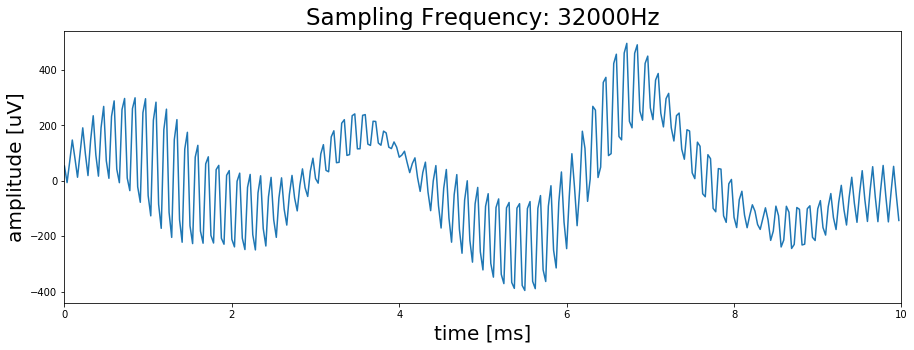

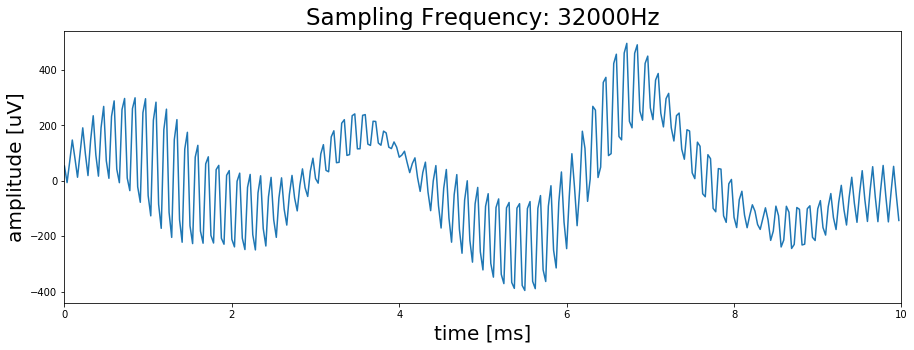

In [278]:
def remove_extreme_amplitudes(samples):
    """
    From Eric's code in Archive.
    Removing the data above 90% of the extremum values.
    """
    min_amplitude = np.min(samples)
    max_amplitude = np.max(samples)
    interval = np.array([min_amplitude, max_amplitude])

    valid_interval = interval * 0.90

    low_bool = samples <= valid_interval[0]
    high_bool = samples >= valid_interval[1]
    print(sum(low_bool))
    print(sum(high_bool))
    
    bad_amplitudes_mask = np.logical_or(low_bool, high_bool)
    print(np.isnan(bad_amplitudes_mask).any())
    print(sum(bad_amplitudes_mask)) #gives 0: all in False

    filtered_samples = samples
    filtered_samples[bad_amplitudes_mask] = np.nan
    return filtered_samples

samples_extreme = remove_extreme_amplitudes(samples_firwin_ravel)
print(sum(samples_firwin_ravel))
plot_samples(samples_firwin_ravel, n_ms=10)
plot_samples(samples_extreme, n_ms=10)

In [274]:
a = [False, True]
sum(a)

1

In [109]:
# Removing data around flat regions of the raw data
slopes = np.diff(samples, axis=0)
flat_x, flat_y = np.where(slopes==0) # ??
print(flat_x.shape)
print(flat_y.shape)
num_samples, num_channels = filt_samples.shape

# TODO(nina): check indices as matlab numerotation is diferent
for c in range(num_channels):
    channel = flat_x[flat_y == c]
    dchannel = np.diff(channel, axis=0)
    #print('Channels:')
    #print(channel.shape)
    #print(dchannel.shape)
    flat_idxs = np.where(dchannel==1)[0]
    #print(flat_idxs.shape)

    # Where it is flat and we can remove altogether
    consec = consecutiveIntegers(flat_idxs, ops_min_consecutive)
    #print(consec)
    
    for i in range(len(consec)):  # Each block of flat thing to remove
        start_idx = channel[consec[i]['start_idx']]
        start_idx = np.max([1, start_idx - ops_flat_window])  # Add window
        
        end_idx = channel[consec[i]['end_idx']] 
        end_idx = np.min([num_samples, end_idx + ops_flat_window])  # Add window
        filt_samples[start_idx:end_idx, c] = np.nan

nanmean = np.nanmean(filt_samples)
nanstd = np.nanstd(filt_samples)
filt_samples = (filt_samples - nanmean) / nanstd

(50863, 512)
(50863, 512)
(50863, 512)
(20800,)
(20800,)


In [110]:
def mad(data, axis=None):
    return np.mean(np.absolute(data - np.mean(data, axis)), axis)

In [136]:
def findMinima(data, threshold):
    """ 
    %% Finds peaks in our data
    % Code based from Abdul's code &
    https://www.frontiersin.org/articles/10.3389/fnins.2016.00537/full
    
    data is a num_samples x num_channels matrix
    peaks is a num_samples x num_channels binary matrix:
     1 if there is a peak, 0 if not
    Peaks are defined as minima threshold*std away from 0
    """
    num_samples, num_channels = data.shape
    # Estimate std from the MAD more robust to noise
    std = 1.4826 * mad(data)
    thresh_mat = - threshold * std * np.ones([num_samples-2, 1])
    d_data = np.diff(data, axis=0)
    
    bool_neg = d_data[:-1, :] < 0
    bool_pos = d_data[1:,:] > 0
    bool_thres = data[1:-1,:] < thresh_mat

    minima = np.logical_and(bool_neg, bool_pos)
    minima = np.logical_and(minima, bool_thres)

    minima = minima.astype(int)

    # Pad it back to get the same shape like data
    # minima = [zeros(1, num_channels); minima; zeros(1, num_channels)];
    pad = np.zeros([1, num_channels])
    minima = np.vstack([pad, minima, pad])

    return minima

In [137]:
peaks = findMinima(filt_samples, ops_spike_threshold)

In [142]:
peakData = {}
    
peaks = findMinima(filt_samples, ops_spike_threshold)

c = 0

for i in range(num_channels):
    # where there are peaks in this channel
    channel_peak_locs = np.where(peaks[:, i])[0]
    # print(channel_peak_locs)

    for j in range(len(channel_peak_locs)):
        peak_idx = channel_peak_locs[j]
        amplitude = filt_samples[peak_idx,i]
        peakData[c]['global_loc'] = peak_idx
        peakData[c]['channel'] = i
        peakData[c]['amplitude'] = amplitude
        c += 1

In [143]:
peakData

{}